**Author:** Andrew Milko (apmilko@outlook.com)

In [1]:
import math
import json
import random
import numpy as np
import matplotlib.pyplot as plt

# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/jckantor/ND-Pyomo-Cookbook/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_ipopt()

Installing pyomo from idaes_pse via pip ... installation successful
Installing ipopt and k_aug on Google Colab via idaes get-extensions ... installation successful


True

In [2]:
from pyomo.environ import *
from pyomo.dae import *

In [3]:
# parameters
ar_max = 0.6
av_max = 0.6
phi_max = 0.7
v_max  = 0.5
v_min = 0

# time and length scales
tf = 8
# L = 0.505
L = 0.4
wheel_r = 0.055
half_width = 0.313 / 2

# primitive poses amount
poses_count = 25

# range yaw values
min_yaw = -math.pi
max_yaw = math.pi

# params
resolution = 0.2
primitives_dict = dict()
primitives_dict_index = 0

In [4]:
def create_primitive(
  start_x, start_y, start_yaw,
  end_x, end_y, end_yaw,
  density=40
  ):
  # create a model object
  m = ConcreteModel()

  # define the independent variable
  m.t = ContinuousSet(bounds=(0, tf))

  # define control inputs
  m.av = Var(m.t)
  m.phi = Var(m.t, bounds=(-phi_max, phi_max))

  # define the dependent variables
  m.x = Var(m.t)
  m.y = Var(m.t)
  m.a = Var(m.t)
  m.v = Var(m.t)

  # define derivatives
  m.x_dot = DerivativeVar(m.x)
  m.y_dot = DerivativeVar(m.y)
  m.a_dot = DerivativeVar(m.a)
  m.v_dot = DerivativeVar(m.v)

  # define the differential equation as constraints

  @m.Constraint(m.t)
  def ode_x(m, t):
      return m.x_dot[t] == m.v[t]*cos(m.a[t])

  @m.Constraint(m.t)
  def ode_y(m, t):
      return m.y_dot[t] == m.v[t]*sin(m.a[t])

  @m.Constraint(m.t)
  def ode_a(m, t):
      return m.a_dot[t] == m.v[t]*tan(m.phi[t])/L

  @m.Constraint(m.t)
  def ode_v(m, t):
      return m.v_dot[t] == m.av[t]

  # path constraints
  m.path_v1 = Constraint(m.t, rule=lambda m, t: m.v[t] <= v_max)
  m.path_v2 = Constraint(m.t, rule=lambda m, t: m.v[t] >= v_min)
  m.path_a1 = Constraint(m.t, rule=lambda m, t: m.av[t] <= av_max)
  m.path_a2 = Constraint(m.t, rule=lambda m, t: m.av[t] >= -av_max)
  m.path_a3 = Constraint(m.t, rule=lambda m, t: m.v[t]**2*sin(m.phi[t])/L <= ar_max)
  m.path_a4 = Constraint(m.t, rule=lambda m, t: m.v[t]**2*sin(m.phi[t])/L >= -ar_max)

  # initial conditions
  m.pc = ConstraintList()
  m.pc.add(m.x[0]==start_x)
  m.pc.add(m.y[0]==start_y)
  m.pc.add(m.a[0]==start_yaw)
  m.pc.add(m.v[0]==0)

  # final conditions
  m.pc.add(m.x[tf]==end_x)
  m.pc.add(m.y[tf]==end_y)
  m.pc.add(m.a[tf]==end_yaw)
  m.pc.add(m.v[tf]==0)

  # final conditions on the control inputs
  m.pc.add(m.av[tf]==0)
  m.pc.add(m.phi[tf]==0)

  # define the optimization objective
  m.integral = Integral(m.t, wrt=m.t, rule=lambda m, t: m.av[t]**2 + (m.v[t]**2*sin(m.phi[t])/L)**2)
  m.obj = Objective(expr=m.integral)

  # transform and solve
  TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=density)
  SolverFactory('ipopt').solve(m)

  # access the results
  t = np.array([t for t in m.t])

  av = np.array([m.av[t]() for t in m.t])
  ar = np.array([(m.v[t]()**2 * np.sin(m.phi[t]()))/L for t in m.t])
  phi = np.array([m.phi[t]() for t in m.t])

  x = np.array([m.x[t]() for t in m.t])
  y = np.array([m.y[t]() for t in m.t])
  a = np.array([m.a[t]() for t in m.t])
  v = np.array([m.v[t]() for t in m.t])

  # convert angles to the interval [-pi, pi]
  for i in range(len(a)):
    a[i] = math.remainder(a[i], 2 * math.pi)
    assert(a[i] >= min_yaw and a[i] <= max_yaw)

  return t, av, ar, phi, x, y, a, v

In [5]:
def plot_results(t, x, y, a, v, av, phi):
  fig, ax = plt.subplots(3,1, figsize=(10,8))

  ax[0].plot(t, av, t, v**2*np.sin(phi)/L)
  ax[0].legend(['Acceleration','Lateral Acceleration'])

  ax[1].plot(t, phi, t, a)
  ax[1].legend(['Wheel Position','Car Direction'])

  ax[2].plot(t, v)
  ax[2].legend(['Velocity'])
  ax[2].set_ylabel('m/s')
  for axes in ax:
    axes.grid(True)

In [6]:
def draw_primitive(x, y, a, phi, color, alpha, draw_start_car, draw_finish_car):
  scl=1

  def draw_car(x=0, y=0, a=0, phi=0):
    R = np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])
    car = np.array([[wheel_r, half_width], [-wheel_r, half_width], [0, half_width], [0, -half_width],
                    [wheel_r, -half_width], [-wheel_r, -half_width], [0, -half_width], [0, 0], [L, 0], [L, half_width],
                    [L + wheel_r*np.cos(phi), half_width + wheel_r*np.sin(phi)],
                    [L - wheel_r*np.cos(phi), half_width - wheel_r*np.sin(phi)], [L, half_width],[L, -half_width],
                    [L + wheel_r*np.cos(phi), -half_width + wheel_r*np.sin(phi)],
                    [L - wheel_r*np.cos(phi), -half_width - wheel_r*np.sin(phi)]])
    carz = scl*R.dot(car.T)
    ax.plot(x + carz[0], y + carz[1], 'k', lw=2, alpha=0.25)
    ax.plot(x, y, 'k.', ms=10, color='black', alpha=0.25)

  #for xs,ys,ts,ps in zip(x, y, a, phi):   
  #    draw_car(xs, ys, ts, scl*ps)
  if draw_start_car:
    draw_car(x[0], y[0], a[0], scl*phi[0])
  if draw_finish_car:
    draw_car(x[-1], y[-1], a[-1], scl*phi[-1])
  ax.plot(x[-1], y[-1], 'k.', ms=10, color='black', alpha=0.25)

  density = np.arange(-resolution * 6, resolution * 6, resolution)
  ax.plot(x, y, color, lw=3, alpha=alpha)
  ax.set_xticks(density)
  ax.set_yticks(density)

In [7]:
def rnd_color():
  return "#"+''.join([random.choice('0123456789abcdef') for j in range(6)])

In [8]:
def export_primitive_json(x, y, a):
  global primitives_dict_index
  primitive_key = 'primitive_{}'.format(primitives_dict_index)
  primitives_dict[primitive_key] = {}

  primitives_dict[primitive_key]['poses'] = {}
  primitives_dict[primitive_key]['length'] = 0.0

  primitives_dict[primitive_key]['neighbor_id'] = {}
  primitives_dict[primitive_key]['neighbor_id']['x'] = round(round(x[-1] - x[0], 1) / resolution)
  primitives_dict[primitive_key]['neighbor_id']['y'] = round(round(y[-1] - y[0], 1) / resolution)

  for i in range(len(x)):
      current_pose_index = 'pose_{}'.format(i)
      prev_pose_index = 'pose_{}'.format(i - 1)
      primitives_dict[primitive_key]['poses'][current_pose_index] = {}
      primitives_dict[primitive_key]['poses'][current_pose_index]['x'] = x[i]
      primitives_dict[primitive_key]['poses'][current_pose_index]['y'] = y[i]
      primitives_dict[primitive_key]['poses'][current_pose_index]['yaw'] = a[i]

      if i > 0:
        primitives_dict[primitive_key]['length'] += \
          sqrt((x[i] - x[i - 1]) ** 2 + (y[i] - y[i - 1]) ** 2)

  primitives_dict_index += 1

In [9]:
def generate_primitives(
    angle,
    sp,
    ep,
    color,
    draw_start_car=True,
    draw_finish_car=True,
    export=False,
    alpha = 0.8
  ):
  for cur_ep in ep:
    assert (sp[0] * 10 / 2) == int(sp[0] * 10 / 2)
    assert (cur_ep[0] * 10 / 2) == int(cur_ep[0] * 10 / 2)
    assert (cur_ep[1] * 10 / 2) == int(cur_ep[1] * 10 / 2)

    t, av, ar, phi, x, y, a, v = \
      create_primitive(
        sp[0], sp[1], sp[2],
        cur_ep[0], cur_ep[1], cur_ep[2],
        density=(poses_count - 1)
      )

    draw_primitive(x, y, a, phi, color, alpha, draw_start_car, draw_finish_car)

    if export:
      # export_primitive(x, y, a)
      export_primitive_json(x, y, a)
      

## Primitives Groups
___

`Group #1`

In [10]:
angle = 90


yaw11 = math.radians(angle)

sp11 = (0, 0, math.radians(angle))

ep11 = [
      (0, 0.6, math.radians(angle)),
      (0.4, 0.6, math.radians(angle - 60)),
      (-0.4, 0.6, math.radians(angle + 60)),
    ]


yaw12 = math.radians(90 - angle)

sp12 = (0, 0, math.radians(90 - angle))

ep12 = [
      (0.6, 0, math.radians(90 - angle)),
      (0.6, 0.4, math.radians(90 - angle + 60)),
      (0.6, -0.4, math.radians(90 - angle - 60)),
    ]


yaw13 = math.radians(90 + angle)

sp13 = (0, 0, math.radians(90 + angle))

ep13 = [
      (-0.6, 0, math.radians(90 + angle)),
      (-0.6, 0.4, math.radians(90 + angle - 60)),
      (-0.6, -0.4, math.radians(90 + angle + 60)),
    ]


yaw14 = math.radians(180 + angle)

sp14 = (0, 0, math.radians(180 + angle))

ep14 = [
      (0, -0.6, math.radians(180 + angle)),
      (0.4, -0.6, math.radians(180 + angle + 60)),
      (-0.4, -0.6, math.radians(180 + angle - 60)),
    ]

<ipython-input-6-4f09490d7e71>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(x, y, 'k.', ms=10, color='black', alpha=0.25)
<ipython-input-6-4f09490d7e71>:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(x[-1], y[-1], 'k.', ms=10, color='black', alpha=0.25)


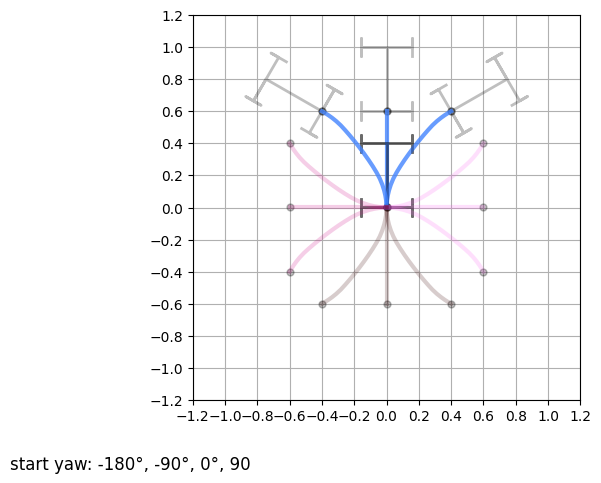

In [11]:
export = False
random.seed(1)

fig, ax = plt.subplots(figsize=(5, 5))
fig.suptitle('start yaw: -180°, -90°, 0°, 90', fontsize=12, x=0, y=0)

generate_primitives(angle, sp11, ep11, rnd_color(), export=export)
generate_primitives(angle, sp12, ep12, rnd_color(), export=export, alpha=0.2, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp13, ep13, rnd_color(), export=export, alpha=0.2, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp14, ep14, rnd_color(), export=export, alpha=0.2, draw_start_car=False, draw_finish_car=False)

ax.grid(True)

`Group #2`

In [12]:
angle = 60


yaw21 = math.radians(angle)

sp21 = (0, 0, math.radians(angle))

ep21 = [
      (0.2, 0.6, math.radians(angle + 30)),
      (0.4, 0.6, math.radians(angle)),
      (0.6, 0.4, math.radians(angle - 30)),
    ]


yaw22 = math.radians(180 - angle)

sp22 = (0, 0, math.radians(180 - angle))

ep22 = [
      (-0.2, 0.6, math.radians(180 - angle - 30)),
      (-0.4, 0.6, math.radians(180 - angle)),
      (-0.6, 0.4, math.radians(180 - angle + 30)),
    ]


yaw23 = math.radians(180 + angle)

sp23 = (0, 0, math.radians(180 + angle))

ep23 = [
      (-0.2, -0.6, math.radians(180 + angle + 30)),
      (-0.4, -0.6, math.radians(180 + angle)),
      (-0.6, -0.4, math.radians(180 + angle - 30)),
    ]


yaw24 = math.radians(360 - angle)

sp24 = (0, 0, math.radians(360 - angle))

ep24 = [
      (0.2, -0.6, math.radians(360 - angle - 30)),
      (0.4, -0.6, math.radians(360 - angle)),
      (0.6, -0.4, math.radians(360 - angle + 30)),
    ]

<ipython-input-6-4f09490d7e71>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(x, y, 'k.', ms=10, color='black', alpha=0.25)
<ipython-input-6-4f09490d7e71>:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(x[-1], y[-1], 'k.', ms=10, color='black', alpha=0.25)


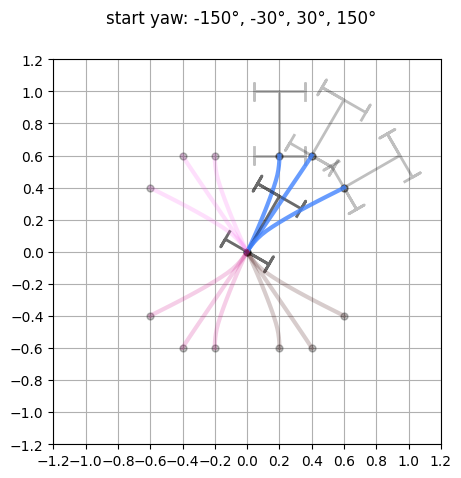

In [13]:
export = False
random.seed(1)

fig, ax = plt.subplots(figsize=(5, 5))
fig.suptitle('start yaw: -150°, -30°, 30°, 150°', fontsize=12)

generate_primitives(angle, sp21, ep21, rnd_color(), export=export)
generate_primitives(angle, sp22, ep22, rnd_color(), export=export, alpha=0.2, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp23, ep23, rnd_color(), export=export, alpha=0.2, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp24, ep24, rnd_color(), export=export, alpha=0.2, draw_start_car=False, draw_finish_car=False)

ax.grid(True)

`Group #3`

In [14]:
angle = 30


yaw31 = math.radians(angle)

sp31 = (0, 0, math.radians(angle))

ep31 = [
      (0.4, 0.6, math.radians(angle + 30)),
      (0.6, 0.2, math.radians(angle - 30)),
      (0.6, 0.4, math.radians(angle)),
    ]


yaw32 = math.radians(180 - angle)

sp32 = (0, 0, math.radians(180 - angle))

ep32 = [
      (-0.4, 0.6, math.radians(180 - angle - 30)),
      (-0.6, 0.2, math.radians(180 - angle + 30)),
      (-0.6, 0.4, math.radians(180 - angle)),
    ]


yaw33 = math.radians(180 + angle)

sp33 = (0, 0, math.radians(180 + angle))

ep33 = [
      (-0.4, -0.6, math.radians(180 + angle + 30)),
      (-0.6, -0.2, math.radians(180 + angle - 30)),
      (-0.6, -0.4, math.radians(180 + angle)),
    ]


yaw34 = math.radians(360 - angle)

sp34 = (0, 0, math.radians(360 - angle))

ep34 = [
      (0.4, -0.6, math.radians(360 - angle - 30)),
      (0.6, -0.2, math.radians(360 - angle + 30)),
      (0.6, -0.4, math.radians(360 - angle)),
    ]

<ipython-input-6-4f09490d7e71>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(x, y, 'k.', ms=10, color='black', alpha=0.25)
<ipython-input-6-4f09490d7e71>:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(x[-1], y[-1], 'k.', ms=10, color='black', alpha=0.25)


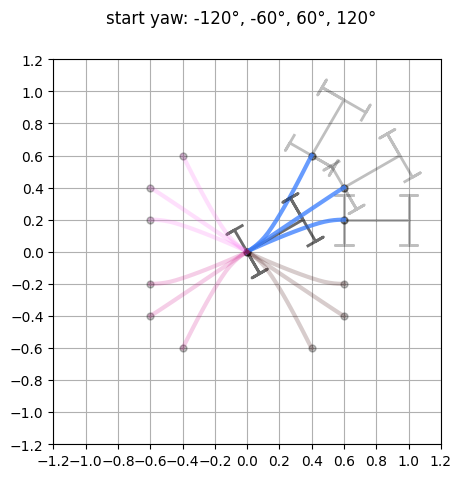

In [15]:
export = False
random.seed(1)

fig, ax = plt.subplots(figsize=(5, 5))
fig.suptitle('start yaw: -120°, -60°, 60°, 120°', fontsize=12)

generate_primitives(angle, sp31, ep31, rnd_color(), export=export)
generate_primitives(angle, sp32, ep32, rnd_color(), export=export, alpha=0.2, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp33, ep33, rnd_color(), export=export, alpha=0.2, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp34, ep34, rnd_color(), export=export, alpha=0.2, draw_start_car=False, draw_finish_car=False)

ax.grid(True)

# `Prepare output json`
___

In [16]:
data = dict()
data

{}

## `Yaws`

In [17]:
yaws = sorted([yaw11, yaw12, yaw13, yaw14,
               yaw21, yaw22, yaw23, yaw24,
               yaw31, yaw32, yaw33, yaw34])

for i in range(len(yaws)):
  yaws[i] = math.remainder(yaws[i], 2 * math.pi)
  assert(yaws[i] >= min_yaw and yaws[i] <= max_yaw)

yaws = sorted(yaws)

In [18]:
yaws

[-2.617993877991494,
 -2.0943951023931957,
 -1.5707963267948966,
 -1.0471975511965974,
 -0.5235987755982991,
 0.0,
 0.5235987755982988,
 1.0471975511965976,
 1.5707963267948966,
 2.0943951023931953,
 2.6179938779914944,
 3.141592653589793]

In [19]:
data['yaws'] = yaws
data

{'yaws': [-2.617993877991494,
  -2.0943951023931957,
  -1.5707963267948966,
  -1.0471975511965974,
  -0.5235987755982991,
  0.0,
  0.5235987755982988,
  1.0471975511965976,
  1.5707963267948966,
  2.0943951023931953,
  2.6179938779914944,
  3.141592653589793]}

## `Edges`

In [21]:
export = True

False

<ipython-input-6-4f09490d7e71>:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(x[-1], y[-1], 'k.', ms=10, color='black', alpha=0.25)


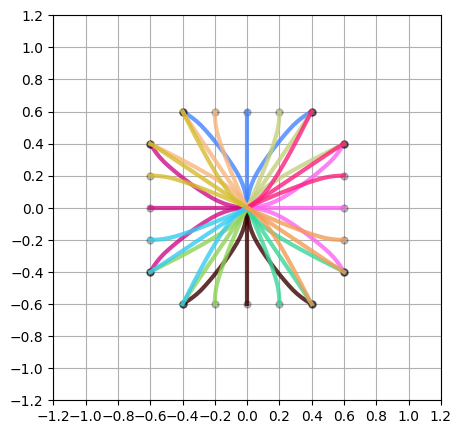

In [22]:
export = True
random.seed(1)

fig, ax = plt.subplots(figsize=(5, 5))

generate_primitives(angle, sp11, ep11, rnd_color(), export=export, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp12, ep12, rnd_color(), export=export, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp13, ep13, rnd_color(), export=export, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp14, ep14, rnd_color(), export=export, draw_start_car=False, draw_finish_car=False)

generate_primitives(angle, sp21, ep21, rnd_color(), export=export, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp22, ep22, rnd_color(), export=export, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp23, ep23, rnd_color(), export=export, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp24, ep24, rnd_color(), export=export, draw_start_car=False, draw_finish_car=False)

generate_primitives(angle, sp31, ep31, rnd_color(), export=export, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp32, ep32, rnd_color(), export=export, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp33, ep33, rnd_color(), export=export, draw_start_car=False, draw_finish_car=False)
generate_primitives(angle, sp34, ep34, rnd_color(), export=export, draw_start_car=False, draw_finish_car=False)

ax.grid(True)

In [23]:
data['primitives'] = primitives_dict

In [24]:
data['yaws']

[-2.617993877991494,
 -2.0943951023931957,
 -1.5707963267948966,
 -1.0471975511965974,
 -0.5235987755982991,
 0.0,
 0.5235987755982988,
 1.0471975511965976,
 1.5707963267948966,
 2.0943951023931953,
 2.6179938779914944,
 3.141592653589793]

In [25]:
data['primitives']['primitive_35']['poses']['pose_0']

{'x': 0.0, 'y': 0.0, 'yaw': -0.5235987755982991}

In [26]:
data['primitives']['primitive_35']['length']

0.7211660066125529

In [27]:
data['primitives']['primitive_35']['neighbor_id']

{'x': 3, 'y': -2}

In [28]:
data['resolution'] = 0.2

In [29]:
data.keys()

dict_keys(['yaws', 'primitives', 'resolution'])

___

In [30]:
with open('data.json', 'w') as f:
    json.dump(data, f)

___
___